# Exercise Sheet 5 - Variational Autoencoders

- Deep Learning for Computer Vision - Winter Term 2024/25
- Lecture by: Constantin Pape
- Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair
- Due date: **Tuesday, Jan 14, before 10:00**

In this exercise a variational autoencoder (VAE) shall be implemented and trained on the fashion MNIST dataset. VAEs are an example of generative deep learning and can be used to synthesize data - images in this case - which shall also be demonstrated in this exercise!

### IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all the questions in written form**
- When you're done, download the notebook and **rename** it to ```<surname1>_<surname2>_<surname3>.ipynb```
- Only submit the Jupyter Notebook (.ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 5` -> `Tutorial X` (where, X is the tutorial you are assigned to).
- Make only one submission of the exercise per group.
- The deadline is strict
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand.

### TASKS
* TASK 1: Implement a VAE
* TASK 2: Train the model and plot train and test set loss over training in the same plot
* TASK 3: Determine optimal dimensionality of latent space
* TASK 4: Plot some latent traversals
* TASK 5: Visualize class labels in latent space

## Setup and Requirements

### Imports

In [1]:
from __future__ import print_function
import pathlib

import matplotlib.pyplot as plt

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.utils

import numpy as np

!nvcc --version
!python --version
print(torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Python 3.10.12
2.5.1+cu121


### Basic setup

Define various global parameters used throughout the notebook!

In [2]:
# Try to use GPU if available
use_cuda = True

# Path for data
data_dir = pathlib.Path('data/')

# Batch size
batch_size = 128

# Image size (same size in both dimensions)
image_size = 28

# Dimension of the latent space
latent_space_dim = 10

# Number of epochs to train
epochs = 5

# How many batches to skip before logging training status
log_interval = 100

# Exponential averaging factor for loss graphs
exp_average_factor = 0.90

# Define beta (weighting of regularization loss)
beta = 1

# Channels in the convolutional layers
capacity = 32

# Learning rate for the optimizer
learning_rate = 1e-3

# Define size / zoom level of plots
plot_zoom = 2
plot_w, plot_h = plt.figure().get_size_inches()
plot_w = plot_w * plot_zoom; plot_h = plot_h * plot_zoom;

<Figure size 640x480 with 0 Axes>

Test if a GPU (CUDA) is available in the environment and use it if it is. Otherwise use the CPU.

In [3]:
if use_cuda and not torch.cuda.is_available():
    print("Error: cuda requested but not available, will use cpu instead!")
    device = torch.device('cpu')

elif not use_cuda:
    print("Info: will use cpu!")
    device = torch.device('cpu')

else:
    print("Info: cuda requested and available, will use gpu!")
    device = torch.device('cuda')

Info: cuda requested and available, will use gpu!


## Get and preprocess the data


We will use the FashionMNIST data set from Zalando (https://github.com/zalandoresearch/fashion-mnist) for our experiments.  
From the quoted github-repo: "Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."


### Load the data for training and testing

The FashionMNIST dataset is already included in the torchvision datasets with the approriate training and test splits. Run the cell below to use it in this notebook.

In [4]:
# TODO: Load the datasets

# transform = transforms.Compose([
#    transforms.Resize(image_size),
#    transforms.ToTensor(),
#    transforms.Normalize((0.1307,), (0.3081,))
# ])

# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_dataset  = datasets.FashionMNIST(data_dir, train=False, transform=transforms.ToTensor())

# train_dataset = datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transforms.ToTensor())
# test_dataset = datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())

For comparison, you can also use the well known MNIST dataset, which is also already included in the torchvision datasets with the approriate training and test splits. Just run the cell included in the appendix instead if you want to use it in this notebook.

Define data loaders for the training and test sets which return batches of samples.

In [5]:
# TODO: Define the data loaders

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Plot the data

To get an impression of the dataset plot some random exemplary pictures.

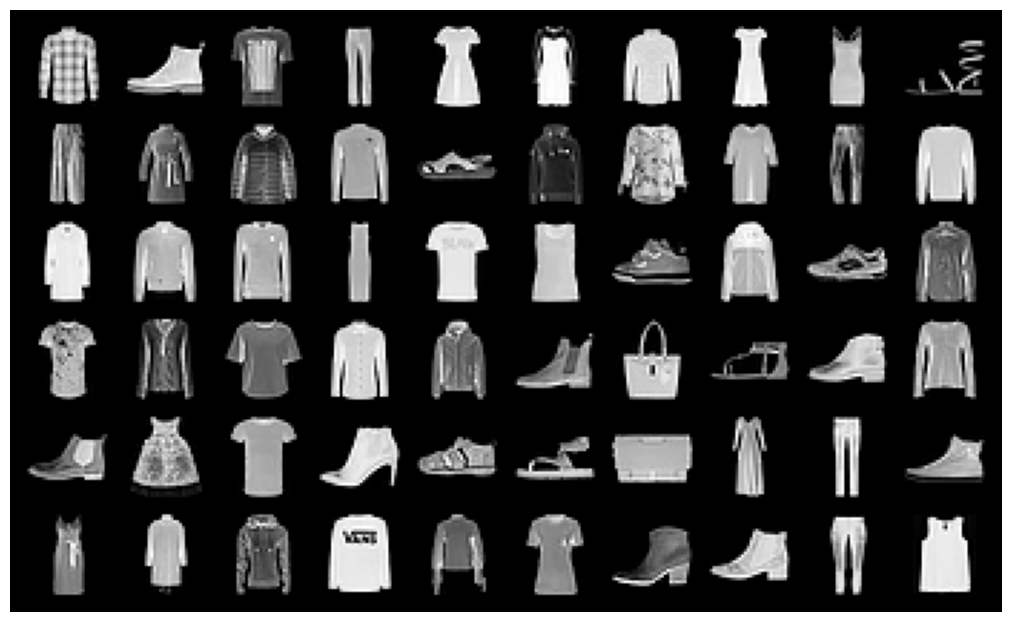

In [6]:
images_columns = 10
images_rows = 6

def show_grid(images_tensor, images_columns, images_rows):
    image = torchvision.utils.make_grid(images_tensor, images_columns, images_rows)
    image = image.numpy()
    fig = plt.gcf()
    fig.set_size_inches(plot_w, plot_h)
    plt.axis('off')
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

data_iterator = iter(train_loader)
images, labels = next(data_iterator)

show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

## Implement a VAE neural network architecture

### Implement the network architecture

Recall that a VAE roughly consistst of two parts: The encoder (which reduces the number of dimensions and maps the input to the latent space) and the decoder (which reverses the encoding, mapping from the latent space back to the initial space).

In VAEs (compared to standard auto-encoders) we assume that the latent space is generated from a multi-variate normal distribution (N~(μ, σ²)) that is parameterized by two vectors, mean and variance. In the network, we use the log of the variance.

In training, we sample from the distribution using the current values of the two vectors, which are updated in each step. After training, we use the mu value to draw the samples.

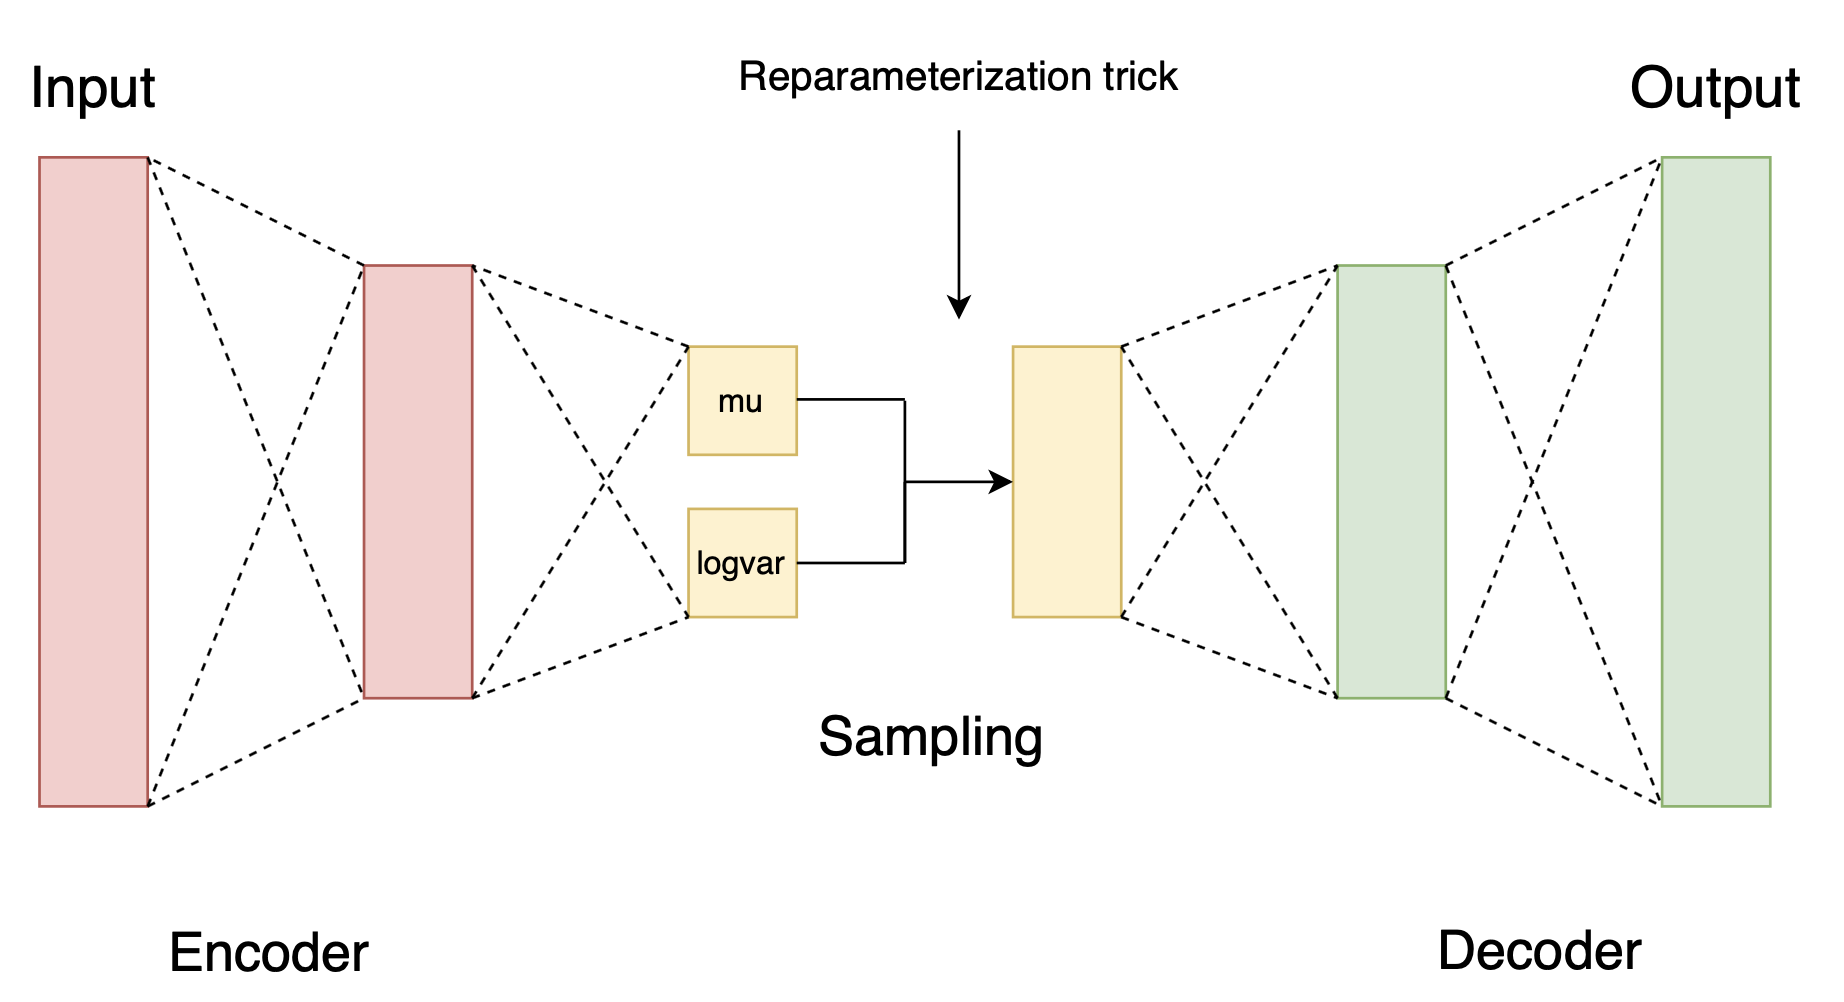

**TASK 1: Implement a VAE with the following network architecture**

We will implement a basic convolutional VAE architecture. Look at the following VAE class specification and implement it accordingly:

**Encoder (sequential model):**
 * Convolutional Layer with (1, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 * Convolutional Layer with (capacity, 2 * capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer

**Sampling:**
* mu, logvar: Linear Layer with 2 * capacity * 7 * 7 input features and latent_dims output features each
* z: Linear Layer with latent_dims input features and 2 * capacity * 7 * 7 output features

**Decoder (sequential model):**
 * ConvTranspose2d Layer with (2 * capacity, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 * ConvTranspose2d Layer with (capacity, 1) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * Sigmoid Activation Layer



**Hint**

For the sampling use the reparameterization trick:

To generate x ~ N(μ, σ²), sample ε ~ N(0, 1). Then x can be computed as x = μ + σε.

Further, remember to differentiate between training and eval: sample in training and return mu in eval.

**TODO** What does the trick do and why do we need it?

**Because sampling from the distrubtion is not differentiable due to the randomness of the sampling process, so we change it so its determnistic .... ϵ introduces the randomness we need for sampling, but it is independent of μ and σ, so gradients can still flow through μ and σ.**

In [7]:
# TODO Implement the VAE
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, capacity, latent_dims):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(capacity, 2 * capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Sampling layers
        self.fc_mu = nn.Linear(2 * capacity * 7 * 7, latent_dims)
        self.fc_logvar = nn.Linear(2 * capacity * 7 * 7, latent_dims)
        self.fc_z = nn.Linear(latent_dims, 2 * capacity * 7 * 7)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2 * capacity, capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(capacity, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)  # Convert logvar to std
        eps = torch.randn_like(std)  # Sample epsilon from N(0, 1)
        return mu + eps * std  # Return reparameterized sample

    def forward(self, x):
        # Encoder
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten for linear layers

        # Sampling
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        if self.training:
            z = self.reparameterize(mu, logvar)
        else:
            z = mu

        z = self.fc_z(z).view(-1, 2 * capacity, 7, 7)  # Reshape back to feature map size

        # Decoder
        decoded = self.decoder(z)
        return decoded, mu, logvar

    def decode(self, z):
        # Decoder for sampling latent variables
        z = self.fc_z(z).view(-1, 2 * capacity, 7, 7)  # Reshape latent vector to feature map
        decoded = self.decoder(z)  # Pass through the decoder
        return decoded

### Implement the loss function

Implement the two parts of the loss function: reconstruction loss using Mean Squared Error (MSE) function and the regularization part of the loss using Kullback-Leibler-Divergence (KLD).

**Hint:**
- Make sure that you use sum instead of mean for calculating the MSE loss!
- Refer to the paper _Auto-Encoding Variational Bayes_ by Kingma and Welling to implement the loss function.

In [8]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction losses are calculated using Mean Squared Error (MSE) and
    # summed over all elements and batch
    mse_loss = F.mse_loss(recon_x, x, reduction='sum')  # TODO

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # TODO

    total_loss = mse_loss + kld_loss

    return total_loss, mse_loss, kld_loss

### Instantiate the model and define the optimizer to use.

In [9]:
model = VAE(capacity = capacity, latent_dims = latent_space_dim)  # TODO
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # TODO

In [10]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=3136, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=10, bias=True)
  (fc_z): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

## Train the network

**TASK 2: Train the model and plot train+test set loss over training in the same plot using the given `plot_losses` function**


In [11]:
def plot_losses(
    train_total_losses=None, train_mse_losses=None, train_kld_losses=None,
    test_epoch_total_losses=None, test_epoch_mse_losses=None, test_epoch_kld_losses=None
):
    x = range(1, len(train_total_losses) + 1)
    train_batches = len(train_loader)

    # set line colors
    train_color_mse   = 'moccasin'
    train_color_kld   = 'skyblue'
    train_color_total = 'palegreen'

    test_color_mse   = 'orange'
    test_color_kld   = 'blue'
    test_color_total = 'green'

    # create figure
    fig, ax1 = plt.subplots()
    fig.set_size_inches(plot_w+2, plot_h)

    # Create total / mse loss axis
    ax1.set_xlabel("Batches (Epoch)")
    ax1.set_ylabel("Total / MSE loss")
    ax1.grid(visible=True, axis='x', linestyle=':')
    ax1.set_xticks(np.arange(0, epochs * train_batches, train_batches))
    labels = [f'{str(item)} ({index})' for index, item in enumerate(ax1.get_xticks().tolist())]
    ax1.set_xticklabels(labels)

    # Plot train-set losses
    ax1.plot(x, train_mse_losses, label="Train reconstruction loss (MSE)", color=train_color_mse)
    ax1.plot(np.nan, label = 'Train regularization loss (KLD)', color=train_color_kld) # add legend entry for KLD
    ax1.plot(x, train_total_losses, label="Train total loss", color=train_color_total)

    # Compute test-set epoch average losses
    test_total_losses=[]; test_mse_losses=[]; test_kld_losses=[]
    for epoch in range(epochs):
        test_total_losses += [test_epoch_total_losses[epoch] for i in range(train_batches)]
        test_mse_losses   += [test_epoch_mse_losses[epoch] for i in range(train_batches)]
        test_kld_losses   += [test_epoch_kld_losses[epoch] for i in range(train_batches)]

    # Plot test-set losses
    ax1.plot(x, test_epoch_mse_losses, label="Test reconstruction loss (MSE)", color=test_color_mse)
    ax1.plot(np.nan, label = 'Test regularization loss (KLD)', color=test_color_kld) # add legend entry for KLD
    ax1.plot(x, test_epoch_total_losses, label="Test total loss", color=test_color_total)


    # Create kld loss twin axis
    # print(test_epoch_kld_losses)
    ax2 = ax1.twinx()
    ax2.set_ylabel("KLD loss")
    ax2.plot(x, train_kld_losses, label="Train regularization loss (KLD)", color=train_color_kld)
    ax2.plot(x, test_epoch_kld_losses, label="Test regularization loss (KLD)", color=test_color_kld)

    ax1.legend(loc='center right', framealpha=1, bbox_to_anchor=(1.3, 0.5))

    fig.tight_layout()
    plt.show()

In [12]:
import torch

def train_epoch(model, train_loader, optimizer, device):
    model.train()
    train_loss, mse_loss, kld_loss = 0, 0, 0

    for x, _ in train_loader:
        x = x.to(device)  # Ensure the input is on the correct device
        optimizer.zero_grad()

        recon_x, mu, logvar = model(x)
        total_loss, batch_mse_loss, batch_kld_loss = vae_loss(recon_x, x, mu, logvar)

        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()
        mse_loss += batch_mse_loss.item()
        kld_loss += batch_kld_loss.item()

    return train_loss / len(train_loader), mse_loss / len(train_loader), kld_loss / len(train_loader)

def test_epoch(model, test_loader, device):
    model.eval()
    test_loss, test_mse_loss, test_kld_loss = 0, 0, 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)  # Ensure the input is on the correct device

            recon_x, mu, logvar = model(x)
            total_loss, batch_mse_loss, batch_kld_loss = vae_loss(recon_x, x, mu, logvar)

            test_loss += total_loss.item()
            test_mse_loss += batch_mse_loss.item()
            test_kld_loss += batch_kld_loss.item()

    return test_loss / len(test_loader), test_mse_loss / len(test_loader), test_kld_loss / len(test_loader)

def run_experiment(model, train_loader, test_loader, optimizer, device, epochs):
    train_total_losses, train_mse_losses, train_kld_losses = [], [], []
    test_epoch_total_losses, test_epoch_mse_losses, test_epoch_kld_losses = [], [], []

    model = model.to(device)
    for epoch in range(1, epochs + 1):
        # Train the model
        train_loss, mse_loss, kld_loss = train_epoch(model, train_loader, optimizer, device)
        train_total_losses.append(train_loss)
        train_mse_losses.append(mse_loss)
        train_kld_losses.append(kld_loss)

        # Test the model
        test_loss, test_mse_loss, test_kld_loss = test_epoch(model, test_loader, device)
        test_epoch_total_losses.append(test_loss)
        test_epoch_mse_losses.append(test_mse_loss)
        test_epoch_kld_losses.append(test_kld_loss)

        print(f"Epoch {epoch}: Train Loss: {train_total_losses[-1]:.4f}, Test Loss: {test_epoch_total_losses[-1]:.4f}")

    return train_total_losses, train_mse_losses, train_kld_losses, test_epoch_total_losses, test_epoch_mse_losses, test_epoch_kld_losses


train_total_losses, train_mse_losses, train_kld_losses, test_epoch_total_losses, test_epoch_mse_losses, test_epoch_kld_losses = run_experiment(
    model = model, train_loader = train_loader, test_loader = test_loader, optimizer = optimizer, device = device, epochs = epochs
)


Epoch 1: Train Loss: 4539.2891, Test Loss: 3112.2824
Epoch 2: Train Loss: 3532.4966, Test Loss: 2975.3398
Epoch 3: Train Loss: 3418.4192, Test Loss: 2940.8091
Epoch 4: Train Loss: 3356.7447, Test Loss: 2874.3872
Epoch 5: Train Loss: 3314.1045, Test Loss: 2818.5524


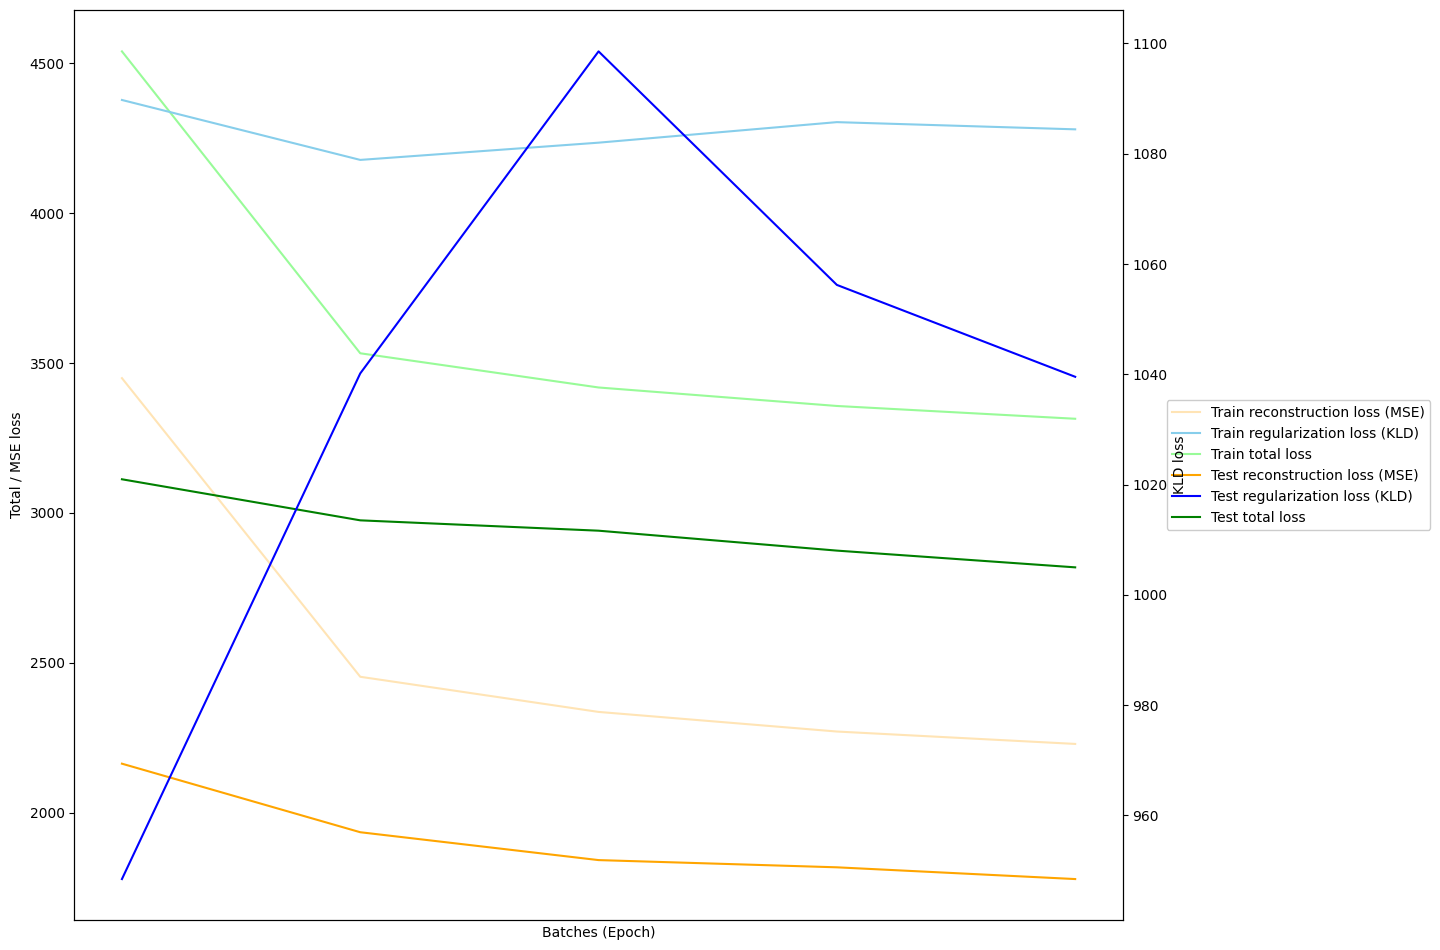

In [13]:
# TODO Plot the train and test set loss during training in the same plot
plot_losses(
    train_total_losses,
    train_mse_losses,
    train_kld_losses,
    test_epoch_total_losses,
    test_epoch_mse_losses,
    test_epoch_kld_losses
)


### Visualization of random samples from the latent space via decoding

Here we just create a number of random samples from the latent space and use the decoder to generate images from them. Rerun the code cell to generate new samples every time!

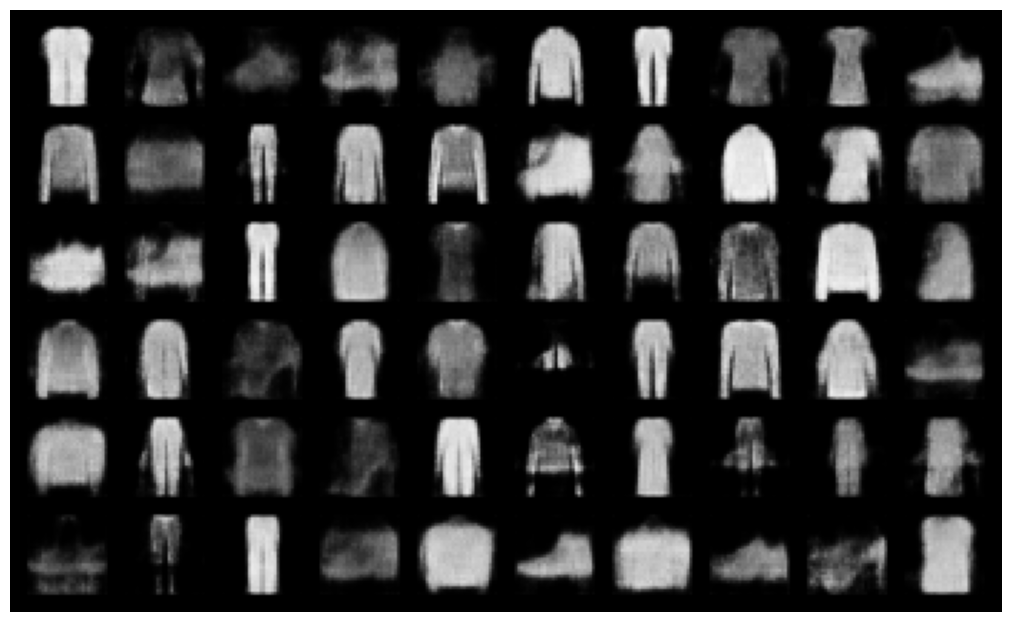

In [14]:
with torch.no_grad():
    samples = torch.randn(images_columns * images_rows, latent_space_dim).to(device)
    samples = model.decode(samples).cpu()

    show_grid(samples[0:(images_columns * images_rows)], images_columns, images_rows)

### Visualization of image reconstructions

Visualize the image reconstruction process and compare the reconstructions to the original images.

Original Images


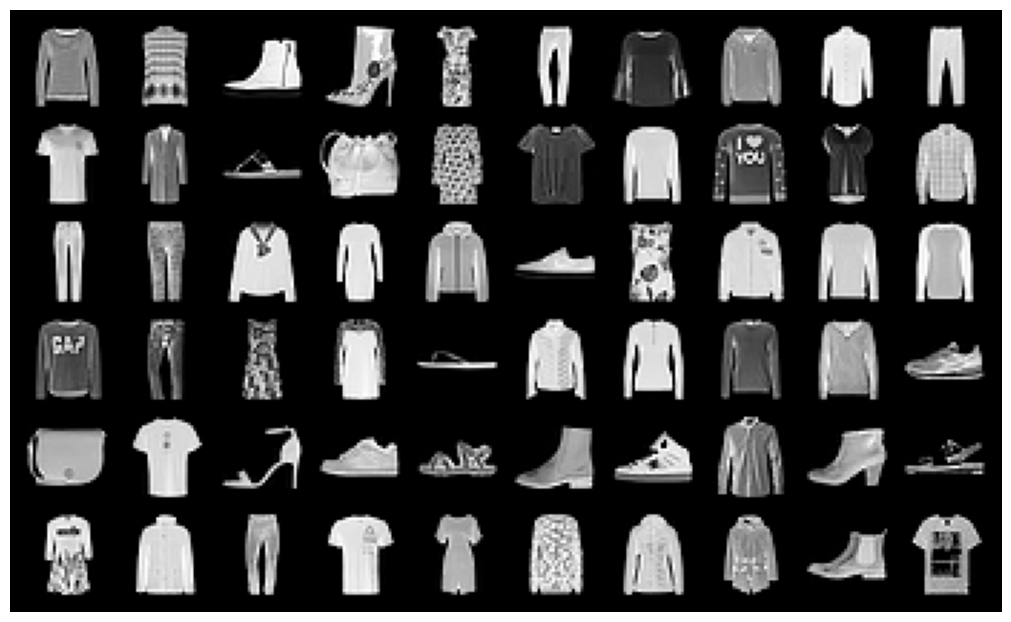

Reconstructed Images


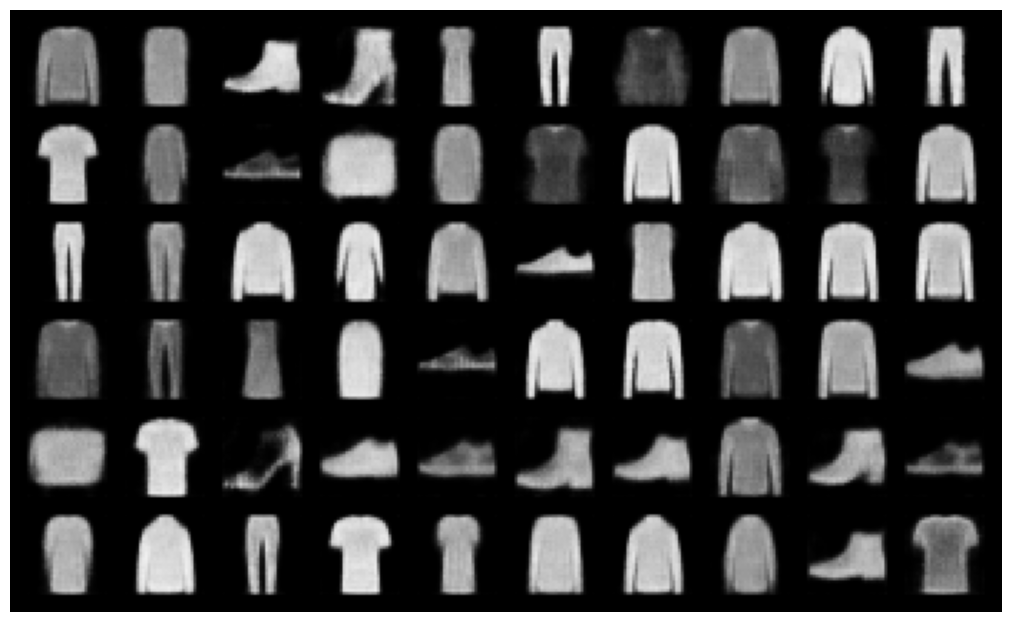

In [15]:
images_columns = 10
images_rows    = 6

data_iterator = iter(train_loader)
images, labels = next(data_iterator)

# Show original images
print("Original Images")
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():

    # TODO: compute reconstruction
    images_recon, mu, logvar = model(images.to(device))
    images_recon = images_recon.cpu()

    print("Reconstructed Images")
    show_grid(images_recon[0:(images_columns * images_rows)], images_columns, images_rows)

### Optimization

**TASK 3: Explore dimensionality of latent space**

How does the dimensionality of latent space (set to 10 by default in our case) affect loss and quality of the reconstructions? Explore smaller and larger latent dimensionality by using 2, 4, 8, 16, 32 dimensions and looking at reconstructions and resulting test set losses.

In [16]:
# TODO: Train models with low dim latent space (2d)

model = VAE(capacity = capacity, latent_dims = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Run the experiment
train_total_losses, train_mse_losses, train_kld_losses, test_epoch_total_losses, test_epoch_mse_losses, test_epoch_kld_losses = run_experiment(
    model = model, train_loader = train_loader, test_loader = test_loader, optimizer= optimizer, device = device, epochs = epochs
)


Epoch 1: Train Loss: 5345.9695, Test Loss: 4051.7624
Epoch 2: Train Loss: 4089.4426, Test Loss: 3851.9792
Epoch 3: Train Loss: 3956.5143, Test Loss: 3758.9573
Epoch 4: Train Loss: 3890.7218, Test Loss: 3685.0157
Epoch 5: Train Loss: 3840.9280, Test Loss: 3625.0907


In [17]:
# TODO: Train models with low dim latent space (4d)

model = VAE(capacity = capacity, latent_dims = 4)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Run the experiment
train_total_losses, train_mse_losses, train_kld_losses, test_epoch_total_losses, test_epoch_mse_losses, test_epoch_kld_losses = run_experiment(
    model = model, train_loader = train_loader, test_loader = test_loader, optimizer= optimizer, device = device, epochs = epochs
)


Epoch 1: Train Loss: 4808.8786, Test Loss: 3441.2472
Epoch 2: Train Loss: 3592.3288, Test Loss: 3230.3897
Epoch 3: Train Loss: 3449.8164, Test Loss: 3112.3496
Epoch 4: Train Loss: 3382.4202, Test Loss: 3119.7945
Epoch 5: Train Loss: 3337.6864, Test Loss: 3084.3251


In [18]:
# TODO: Train models with low dim latent space (8d)

model = VAE(capacity = capacity, latent_dims = 8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Run the experiment
train_total_losses, train_mse_losses, train_kld_losses, test_epoch_total_losses, test_epoch_mse_losses, test_epoch_kld_losses = run_experiment(
    model = model, train_loader = train_loader, test_loader = test_loader, optimizer= optimizer, device = device, epochs = epochs
)


Epoch 1: Train Loss: 4976.2672, Test Loss: 3281.6548
Epoch 2: Train Loss: 3582.4001, Test Loss: 3010.3504
Epoch 3: Train Loss: 3438.3342, Test Loss: 2972.8714
Epoch 4: Train Loss: 3369.1182, Test Loss: 2896.2545
Epoch 5: Train Loss: 3323.1150, Test Loss: 2906.6519


In [19]:
# TODO: Train models with low dim latent space (16d)

model = VAE(capacity = capacity, latent_dims = 16)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Run the experiment
train_total_losses, train_mse_losses, train_kld_losses, test_epoch_total_losses, test_epoch_mse_losses, test_epoch_kld_losses = run_experiment(
    model = model, train_loader = train_loader, test_loader = test_loader, optimizer= optimizer, device = device, epochs = epochs
)


Epoch 1: Train Loss: 5283.3987, Test Loss: 3264.2877
Epoch 2: Train Loss: 3674.0262, Test Loss: 3065.8173
Epoch 3: Train Loss: 3503.4866, Test Loss: 2978.8943
Epoch 4: Train Loss: 3416.6275, Test Loss: 2972.8113
Epoch 5: Train Loss: 3359.7457, Test Loss: 2880.7123


In [20]:
# TODO: Train models with low dim latent space (32d)

model = VAE(capacity = capacity, latent_dims = 32)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Run the experiment
train_total_losses, train_mse_losses, train_kld_losses, test_epoch_total_losses, test_epoch_mse_losses, test_epoch_kld_losses = run_experiment(
    model = model, train_loader = train_loader, test_loader = test_loader, optimizer= optimizer, device = device, epochs = epochs
)


Epoch 1: Train Loss: 5145.3918, Test Loss: 3233.5809
Epoch 2: Train Loss: 3676.0440, Test Loss: 3067.0610
Epoch 3: Train Loss: 3526.0921, Test Loss: 2963.9906
Epoch 4: Train Loss: 3439.3634, Test Loss: 2934.2936
Epoch 5: Train Loss: 3381.7399, Test Loss: 2886.7981


## Visualization of latent traversals

**TASK 4: Plot some latent traversals**

Latent traversal is a popular approach to visualize the disentangled latent representations. Given a bunch of variations in a single unit of the latent representation, it is expected that there is a change in a single factor of variation of the data while others are fixed. (See paper [Learning Disentangled Representations with Latent Variation Predictability](https://arxiv.org/abs/2007.12885))

Remember in the previous task you trained models with different latent dimensions. Each shape is encoded into a `latent_dim`-sized vector. In this task we want to see which shapes are reconstructed if we create a latent code where we set

- one of these dimensions (e.g. dim1=11) to different values ($x_i \in [-3,3]$)
- two of these dimensions (e.g. dim1=31, dim2=4) to different values ($x_i, x_j \in [-3,3]$)

while setting all other values of the latent code to $0$. Use the decoder of the VAE neural network to create images from these latent codes.

**TODO:** Create a 1 x 10 array plot for the first visualization and a 10 x 10 matrix plot for the second showing latent space travels.

**TODO:** Repeat the experiment, now setting the other dimensions of the vector to a random value in [-1,1] instead of zero. Write down what you observe.

Here are two examples.

1x10 traversal of one latent dimension

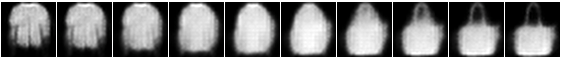

10x10 traversal of two latent dimensions

![10x10 traversal of two latent dimensions](https://i.imgur.com/hZXIYzv.png)

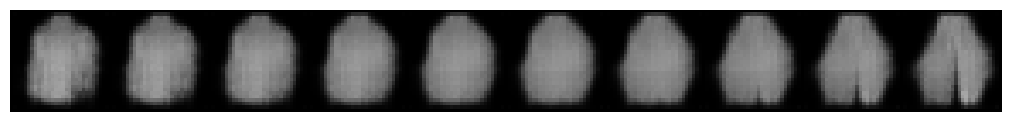

In [52]:
# One dimension traverse

images_columns = 10
images_rows = 1
latent_dim = 32

model.eval()

latent_code = torch.zeros((images_columns, latent_dim)).to(device)
traversal_range = torch.linspace(-3, 3, steps=images_columns).to(device)
for i in range(images_columns):
      latent_code[i, 0] = traversal_range[i]  # Vary the first latent dimension


with torch.no_grad():
      decoded_images = model.decode(latent_code).cpu()
      show_grid(decoded_images, images_columns, images_rows)

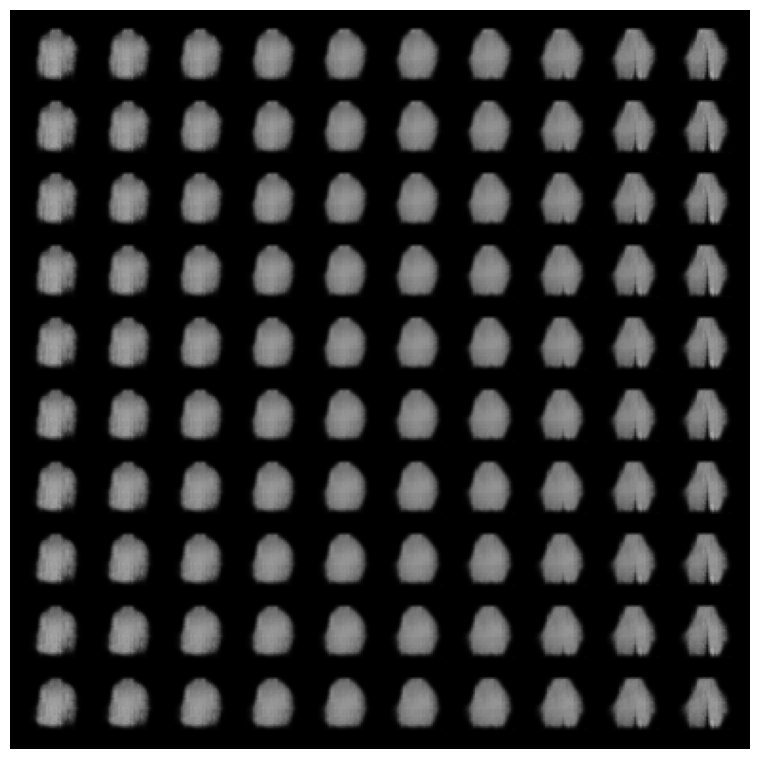

In [55]:
# pair wise dimension traverse

images_columns = 10
images_rows = 10
latent_dim = 32

model.eval()

latent_code = torch.zeros((images_columns * images_rows, latent_dim)).to(device)
traversal_range = torch.linspace(-3, 3, steps=images_columns).to(device)
for i in range(images_columns):
  for j in range(images_rows):
    idx = i * images_columns + j
    latent_code[idx, 0] = traversal_range[j]
    latent_code[idx, 1] = traversal_range[i]


with torch.no_grad():
      decoded_images = model.decode(latent_code).cpu()
      show_grid(decoded_images, images_columns, images_rows)

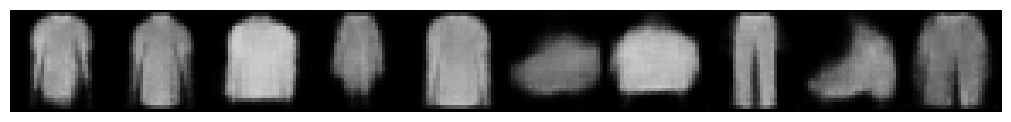

In [60]:
# One dimension traverse (random others)

images_columns = 10
images_rows = 1
latent_dim = 32

model.eval()

latent_code = torch.rand(images_columns, latent_dim).uniform_(-1, 1).to(device)
traversal_range = torch.linspace(-3, 3, steps=images_columns).to(device)
for i in range(images_columns):
      latent_code[i, 0] = traversal_range[i]
with torch.no_grad():
      decoded_images = model.decode(latent_code).cpu()
      show_grid(decoded_images, images_columns, images_rows)

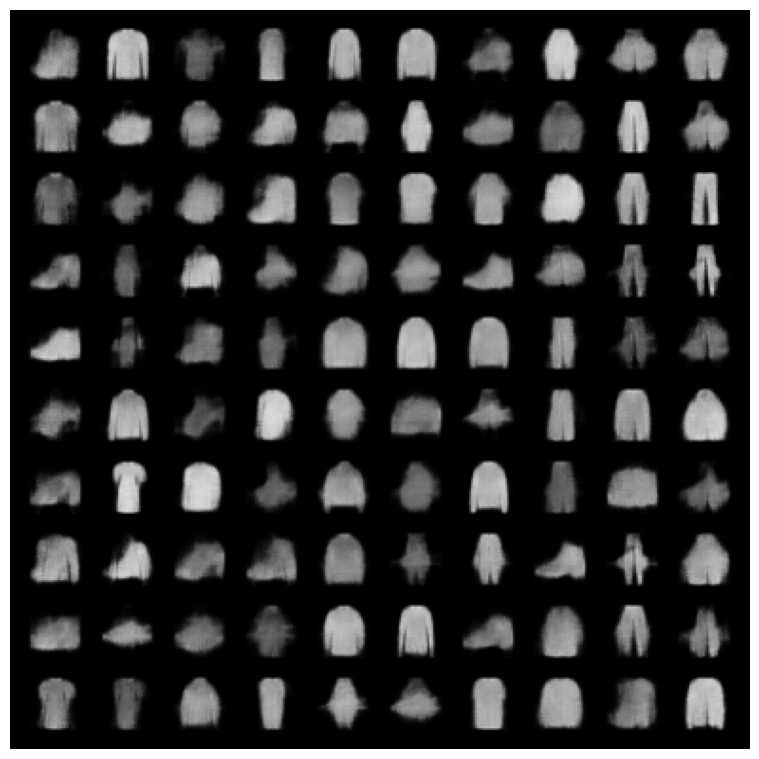

In [61]:
# pair wise dimension traverse

images_columns = 10
images_rows = 10
latent_dim = 32

model.eval()

latent_code = torch.rand(images_columns * images_rows, latent_dim).uniform_(-1, 1).to(device)
traversal_range = torch.linspace(-3, 3, steps=images_columns).to(device)
for i in range(images_columns):
  for j in range(images_rows):
    idx = i * images_columns + j
    latent_code[idx, 0] = traversal_range[j]  # Vary the first latent dimension
    latent_code[idx, 1] = traversal_range[i]  # Vary the second latent dimension


with torch.no_grad():
      decoded_images = model.decode(latent_code).cpu()
      show_grid(decoded_images, images_columns, images_rows)

### Visualize class labels in latent space

**TASK 5: Visualize class labels in latent space**

First create a new VAE-model with a 2d latent space on the full training data set. Then project all the images of the training set into the 2d latent space keeping track of their class labels. Use a 2d scatter plot to visualize the resulting latent space vectors and different colors for their labels.

#### Train 2d latent space model

In [63]:
model = VAE(capacity = capacity, latent_dims = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Run the experiment
train_total_losses, train_mse_losses, train_kld_losses, test_epoch_total_losses, test_epoch_mse_losses, test_epoch_kld_losses = run_experiment(
    model = model, train_loader = train_loader, test_loader = test_loader, optimizer= optimizer, device = device, epochs = epochs
)


Epoch 1: Train Loss: 5347.8556, Test Loss: 4112.1099
Epoch 2: Train Loss: 4156.9016, Test Loss: 3858.5206
Epoch 3: Train Loss: 4013.6821, Test Loss: 3793.8436
Epoch 4: Train Loss: 3948.8746, Test Loss: 3771.4842
Epoch 5: Train Loss: 3903.5926, Test Loss: 3689.1770


VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=3136, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=2, bias=True)
  (fc_z): Linear(in_features=2, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

#### Visualize classes

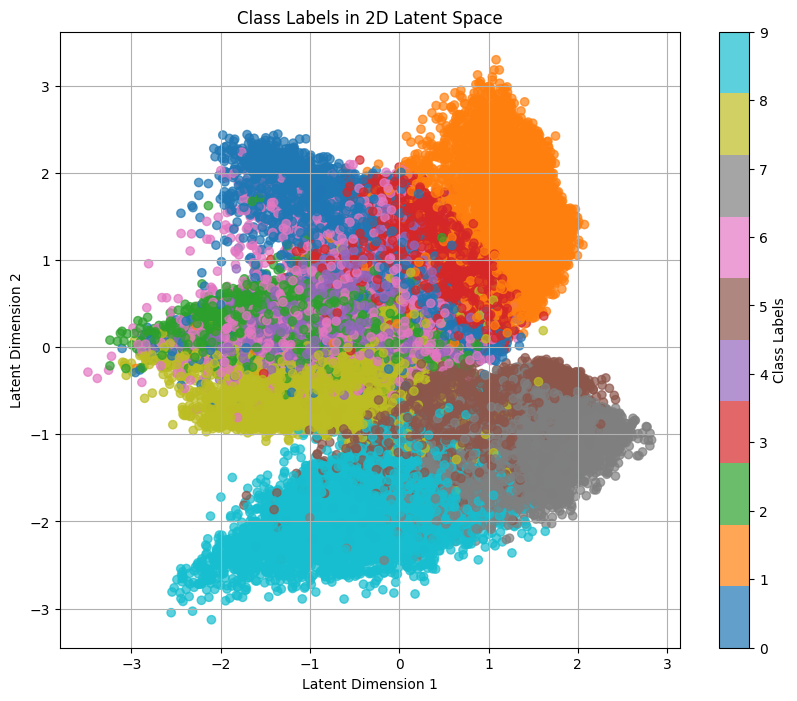

In [65]:
def visualize_latent_space(model, train_loader, device):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for x, y in train_loader:
            x = x.to(device)
            _, mu, _ = model(x)  # Extract the latent mean vector
            latent_vectors.append(mu.cpu().numpy())
            labels.append(y.numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Create a 2D scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap="tab10", alpha=0.7)
    plt.colorbar(scatter, label="Class Labels")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Class Labels in 2D Latent Space")
    plt.grid(True)
    plt.show()
visualize_latent_space(model, train_loader, device)

#### Questions

- Do images of the same class cluster in latent space?
- Do the data points in latent space look like a normal distribution?

* **Yes same class most of the time cluster  except for some cases where they are very close so they interwine a little bit like class 6 and class 4 because the image itself are very similar**
* **not really why ??**


# Appendix *(Optional)*

Use standard MNIST or CIFAR-10 instead of fashion MNIST.

In [ ]:
transform = transforms.Compose([
   transforms.Resize(image_size),
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(data_dir, train=False, transform=transforms.ToTensor())